In [1]:
!pip install pandas
!pip install scikeras[tensorflow]
!pip install imbalanced-learn

In [2]:
!chmod +x /kaggle/input/regression/download.sh
!source /kaggle/input/regression/download.sh

chmod: changing permissions of '/kaggle/input/regression/download.sh': Read-only file system
Files already exist. Skipping download and extraction.


In [3]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as  plt
import gc
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

In [4]:
def alter_data(X):
    X = X.values
    turn = X[:,64]
    black_to_play = np.where(turn == -1)[0]
    # Multiply the values from indexes 0 to 63 by -1 where index 64 is 0
    X[black_to_play, :64] *= -1
    X = X[:, 0:64].reshape((X.shape[0], 8 , 8))
    return X

In [5]:
def load_n_datasets(n,foldername):
    all_datasets = []
    filenames = os.listdir(foldername)
    for i in range(n):
        filename = filenames[i]
        if filename.endswith('.csv'):
            dataset = pd.read_csv(os.path.join(foldername, filename))
            all_datasets.append(dataset)
    combined_dataset = pd.concat(all_datasets, ignore_index=True)
    
    X =  combined_dataset.iloc[:,0:-1]
    y =  combined_dataset["Evaluation"].astype(float)
    combined_dataset = None
    dataset = None
    all_datasets = None
    return X,y

In [6]:
def bit_map(X):
    channels = np.zeros((X.shape[0],8, 8, 12))  # 12 channels for 6 types of pieces for each player
    # Generate separate channels for each player
    for player in range(2):  # 0 for white pieces, 1 for black pieces
        if player ==0:
            for piece_type in range(6):  # 6 types of pieces
                piece_mask = X == (piece_type + 1)
                channels[:, :, :, player * 6 + piece_type] = piece_mask.astype(np.float32)
        else:
            for piece_type in range(6):  # 6 types of pieces
                piece_mask = -1*(X == (-piece_type - 1))
                channels[:, :, :, player * 6 + piece_type] = piece_mask.astype(np.float32)
    X = None
    return channels

In [7]:
n_datasets = 2
X_chess_data,y_chess_data = load_n_datasets(n_datasets,'processed_data')

X = pd.DataFrame(X_chess_data)
y = pd.DataFrame(y_chess_data)

print(type(X_chess_data))
print(X_chess_data.shape)

X = alter_data(X_chess_data)
X = bit_map(X)

<class 'pandas.core.frame.DataFrame'>
(1993542, 69)


In [8]:
y = (y - y.min()) / (y.max()-y.min())

In [9]:
X_chess_data = None
y_chess_data = None
gc.collect()

26

In [10]:
X_train,X_val,y_train,y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_val,X_test,y_val,y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)
#80% training, 10% validation and 10% testing.

In [11]:
X = None
y = None
gc.collect()

0

In [12]:
import tensorflow
from keras.models import Sequential 
from keras.layers import Conv2D, Flatten, BatchNormalization, Dense, Dropout
from keras.activations import elu
from keras.optimizers import SGD,Adam

tensorflow.random.set_seed(101)

In [13]:
def create_model_mlp(input_shape):
    mlp_model = Sequential()

    # Add hidden layers with ReLU activation and dropout
    mlp_model.add(Dense(1048, activation='relu', input_shape=input_shape))
    mlp_model.add(Dropout(0.2))
    mlp_model.add(Dense(500, activation='relu'))
    mlp_model.add(Dropout(0.2))
    mlp_model.add(Dense(50, activation='relu'))
    mlp_model.add(Dropout(0.2))

    # Layer to ensure the output matches the labels in shape
    mlp_model.add(Flatten())
    
    # Add output layer with linear activation for regression
    mlp_model.add(Dense(1, activation='linear'))

    # Compile model with Adam optimizer
    adam = Adam(learning_rate=0.001, beta_1=0.90, beta_2=0.99, epsilon=1e-8)
    mlp_model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mae'])

    # Print model summary
    mlp_model.summary()
    return mlp_model

In [14]:
def create_model_cnn(input_shape):
    cnn_model = Sequential()

    # Add convolutional layers with ELU activation and batch normalization
    cnn_model.add(Conv2D(20, (5, 5), activation=elu, input_shape=input_shape, padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Dropout(0.3))
    
    cnn_model.add(Conv2D(50, (3, 3), activation=elu, padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Dropout(0.3))
    
    # Add fully connected layer
    cnn_model.add(Flatten())
    cnn_model.add(Dense(500, activation=elu))
    cnn_model.add(Dropout(0.3))
    
    # Add output layer with linear activation for regression
    cnn_model.add(Dense(1, activation='sigmoid'))

    # Compile model with SGD optimizer
    sgd = SGD(learning_rate=0.01, nesterov=False)
    cnn_model.compile(optimizer=sgd, loss='mean_squared_error', metrics=['mae'])

    # Print model summary
    cnn_model.summary()
    return cnn_model

In [15]:
def create_model_mlp2(input_shape,num_classes):
    mlp_model = Sequential()

    # Add hidden layers with ReLU activation and dropout
    mlp_model.add(Dense(2048, activation='elu', input_shape=input_shape))
    mlp_model.add(Dropout(0.2))
    mlp_model.add(Dense(2048, activation='elu'))
    mlp_model.add(Dropout(0.2))
    mlp_model.add(Dense(1050, activation='elu'))
    mlp_model.add(Dropout(0.2))

    # Layer to ensure the output matches the labels in shape
    mlp_model.add(Flatten())
    
    # Add output layer with softmax activation
    mlp_model.add(Dense(num_classes, activation='softmax'))

    # Compile model with Adam optimizer
    adam = Adam(learning_rate=0.001, beta_1=0.90, beta_2=0.99, epsilon=1e-8)
    mlp_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    # Print model summary
    mlp_model.summary()
    return mlp_model

In [18]:
def run_model(X_train,y_train,X_val,y_val,batch_size,epochs):

    input_shape = X_train.shape[1:]
    print(input_shape)
    #model = create_model_mlp1(input_shape)
    model = create_model_cnn(input_shape)
    #model = create_model_mlp2(input_shape)
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

    return history,model

In [19]:

batch_size = 128
epochs = 20

history,model = run_model(X_train,y_train,X_val,y_val,batch_size,epochs)

(8, 8, 12)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 8, 8, 20)       │         6,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 50)       │         9,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 50)       │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │     1,600,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,616,351 (6.17 MB)

 Trainable params: 1,616,211 (6.17 MB)

 Non-trainable params: 140 (560.00 B)

Epoch 1/20


I0000 00:00:1713199005.622972     430 service.cc:145] XLA service 0x7c6100008e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713199005.623026     430 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   60/12460 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 0.1002 - mae: 0.2715

I0000 00:00:1713199011.090956     430 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12460/12460 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - loss: 0.0201 - mae: 0.0918 - val_loss: 0.0017 - val_mae: 0.0281
Epoch 2/20
12460/12460 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.0013 - mae: 0.0178 - val_loss: 0.0013 - val_mae: 0.0200
Epoch 3/20
12460/12460 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.0012 - mae: 0.0153 - val_loss: 0.0012 - val_mae: 0.0166
Epoch 4/20
12460/12460 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.0012 - mae: 0.0142 - val_loss: 0.0012 - val_mae: 0.0145
Epoch 5/20
12460/12460 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.0012 - mae: 0.0136 - val_loss: 0.0012 - val_mae: 0.0136
Epoch 6/20
12460/12460 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.0012 - mae: 0.0134 - val_loss: 0.0011 - val_mae: 0.0131
Epoch 7/20
12460/12460 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.0012 - mae: 0.0133 - val_loss: 0.0011 - val_mae: 0.0129
Epoch 8/20
12460/12460 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.0012 - mae: 0.0132 - val_loss: 0.0011 - val_mae: 0.0128
Epoch 9/20
12460/12460 ━━━━

In [20]:
from sklearn.metrics import accuracy_score

loss,acc = model.evaluate(X_test,y_test)

print("Loss:",loss)
print("Accuracy:",acc)

6230/6230 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0011 - mae: 0.0126
Loss: 0.0011140693677589297
Accuracy: 0.01263585314154625


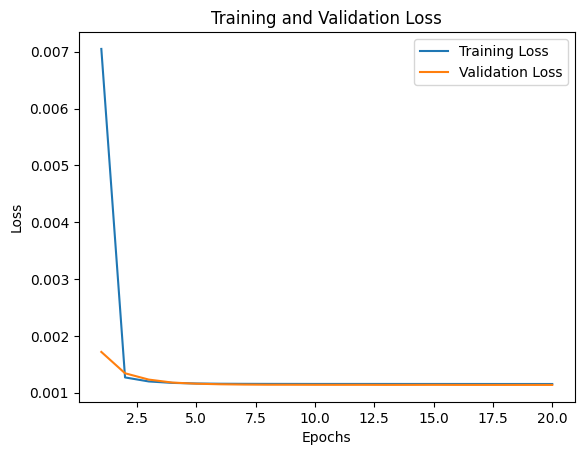

In [25]:
epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('loss_cnn')
plt.show()

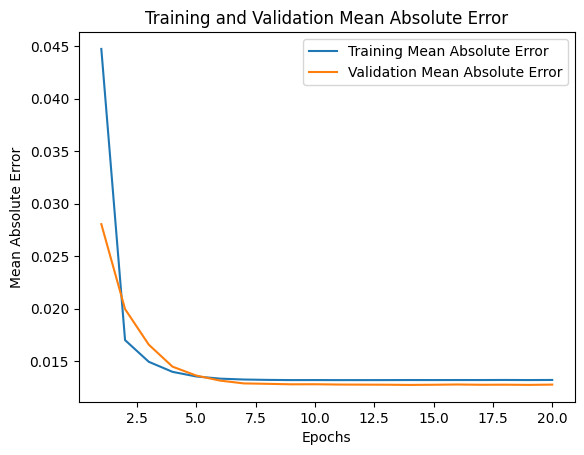

In [26]:
plt.plot(epochs_range, history.history['mae'], label='Training Mean Absolute Error')
plt.plot(epochs_range, history.history['val_mae'], label='Validation Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Training and Validation Mean Absolute Error')
plt.legend()
plt.savefig('mae_cnn')
plt.show()

In [1]:
!pip install stockfish